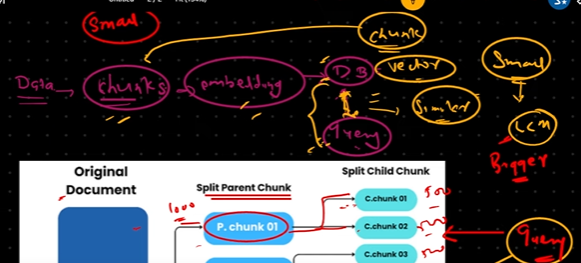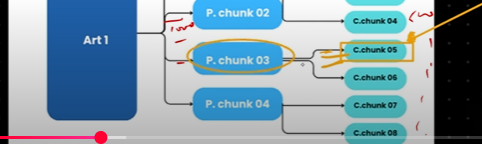

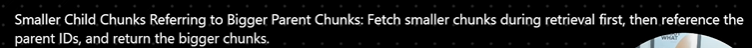

Parent Document Retriever
which issue this parent-child retrieval will solve.

You may want to have small documents, so that their embeddings can most accurately reflect their meaning. If too long, then the embeddings can lose meaning.

You want to have long enough documents that the context of each chunk is retained.

The ParentDocumentRetriever strikes that balance by splitting and storing small chunks of data. During retrieval, it first fetches the small chunks but then looks up the parent ids for those chunks and returns those larger documents.

Note that "parent document" refers to the document that a small chunk originated from. This can either be the whole raw document OR a larger chunk.

In [1]:
from langchain_community.document_loaders import TextLoader

In [2]:
loaders = [
    TextLoader("data/stateoftheunion.txt"),
    TextLoader("data/bidenstateoftheunion.txt"),
]

In [3]:

docs = []

In [4]:
for loader in loaders:
    docs.extend(loader.load()) # add two lists together


In [5]:
docs

[Document(metadata={'source': 'data/stateoftheunion.txt'}, page_content='State of the Union\n\nArticle\nTalk\nRead\nEdit\nView history\n\nTools\nAppearance hide\nText\n\nSmall\n\nStandard\n\nLarge\nWidth\n\nStandard\n\nWide\nColor (beta)\n\nAutomatic\n\nLight\n\nDark\nFrom Wikipedia, the free encyclopedia\nFor the list, see List of State of the Union addresses. For other uses, see State of the Union (disambiguation).\n\nWoodrow Wilson giving his first State of the Union address on December 2, 1913. This was the first time since 1801 that such an address was made in person before a joint session of Congress,[1] initiating the modern trend with regard to the State of the Union address.[2]\nThe State of the Union Address (sometimes abbreviated to SOTU) is an annual message delivered by the president of the United States to a joint session of the United States Congress near the beginning of most calendar years on the current condition of the nation.[3][4] The State of the Union Address gen

In [6]:
# This text splitter is used to create the child documents
from langchain_text_splitters import RecursiveCharacterTextSplitter
child_splitter = RecursiveCharacterTextSplitter(chunk_size=400)


In [7]:

from langchain.storage import InMemoryStore
from langchain_chroma import Chroma

In [8]:

'''# specify embedding model (using huggingface sentence transformer)
from langchain.embeddings import HuggingFaceEmbeddings
embedding_model_name = "sentence-transformers/all-mpnet-base-v2"
model_kwargs = {"device": "cuda"}
embeddings = HuggingFaceEmbeddings(
  model_name=embedding_model_name,
  model_kwargs=model_kwargs
)'''
     

'# specify embedding model (using huggingface sentence transformer)\nfrom langchain.embeddings import HuggingFaceEmbeddings\nembedding_model_name = "sentence-transformers/all-mpnet-base-v2"\nmodel_kwargs = {"device": "cuda"}\nembeddings = HuggingFaceEmbeddings(\n  model_name=embedding_model_name,\n  model_kwargs=model_kwargs\n)'

In [9]:


import os
from dotenv import load_dotenv

load_dotenv()

GOOGLE_API_KEY = os.getenv('GEMINI_API_KEY')
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

In [10]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
gemini_embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

d:\a27_YEARS_OLD\RAG_ranking\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
vectorstore = Chroma(
    collection_name="full_documents", embedding_function=gemini_embeddings
)

In [14]:
vectorstore

In [12]:
store = InMemoryStore()

In [15]:
store

In [13]:

from langchain.retrievers import ParentDocumentRetriever
retriever = ParentDocumentRetriever(
    vectorstore=vectorstore,
    docstore=store,
    child_splitter=child_splitter,
)

In [16]:
retriever

ParentDocumentRetriever(vectorstore=<langchain_chroma.vectorstores.Chroma object at 0x0000017959C4B690>, docstore=<langchain_core.stores.InMemoryStore object at 0x0000017959CE2BD0>, search_kwargs={}, child_splitter=<langchain_text_splitters.character.RecursiveCharacterTextSplitter object at 0x0000017947BCE9D0>)

In [17]:
retriever.add_documents(docs, ids=None)

In [18]:

list(store.yield_keys())

['a2cedfb6-69b5-446c-89be-33d19af9283d',
 'fe11b76e-721f-4deb-92c9-5a864d04b5be']

In [19]:
retrieved_docs= retriever.invoke("What did the president say about Ketanji Brown Jackson")

In [20]:
retrieved_docs

[Document(metadata={'source': 'data/bidenstateoftheunion.txt'}, page_content='President Biden’s State of the Union Address\n(The President presents his prepared remarks to Speaker Johnson.) Your bedtime reading.\n\nTony! Thank you. Looking for Jill.\n\nGood evening. Good evening. If I were smart, I’d go home now.\n\nMr. Speaker, Madam Vice President, members of Congress, my fellow Americans.\n\nIn January 1941, Franklin Roosevelt came to this chamber to speak to the nation. And he said, “I address you at a moment unprecedented in the history of the Union”. Hitler was on the march. War was raging in Europe.\n\nPresident Roosevelt’s purpose was to wake up Congress and alert the American people that this was no ordinary time. Freedom and democracy were under assault in the world.\n\nTonight, I come to the same chamber to address the nation. Now it’s we who face an unprecedented moment in the history of the Union.\n\nAnd, yes, my purpose tonight is to wake up the Congress and alert the Ame

In [21]:
print(retrieved_docs[0].page_content)

President Biden’s State of the Union Address
(The President presents his prepared remarks to Speaker Johnson.) Your bedtime reading.

Tony! Thank you. Looking for Jill.

Good evening. Good evening. If I were smart, I’d go home now.

Mr. Speaker, Madam Vice President, members of Congress, my fellow Americans.

In January 1941, Franklin Roosevelt came to this chamber to speak to the nation. And he said, “I address you at a moment unprecedented in the history of the Union”. Hitler was on the march. War was raging in Europe.

President Roosevelt’s purpose was to wake up Congress and alert the American people that this was no ordinary time. Freedom and democracy were under assault in the world.

Tonight, I come to the same chamber to address the nation. Now it’s we who face an unprecedented moment in the history of the Union.

And, yes, my purpose tonight is to wake up the Congress and alert the American people that this is no ordinary moment either. Not since President Lincoln and the Civi

In [22]:
print(len(retrieved_docs[0].page_content))

24449


In [23]:
# It should create documents smaller than the parent
child_splitter = RecursiveCharacterTextSplitter(chunk_size=500)

In [24]:
child_splitter

In [25]:

# This text splitter is used to create the parent documents
parent_splitter = RecursiveCharacterTextSplitter(chunk_size=2000)

In [26]:
parent_splitter

In [27]:

# The storage layer for the parent documents
store1 = InMemoryStore()

In [31]:
store1

In [28]:
vectorstore1 = Chroma(
    collection_name="full_documents", embedding_function=gemini_embeddings
)

In [32]:
vectorstore1

In [29]:
retriever2 = ParentDocumentRetriever(
    vectorstore=vectorstore1,
    docstore=store1,
    child_splitter=child_splitter,
    parent_splitter=parent_splitter,
)

In [ ]:
# This line creates an instance of ParentDocumentRetriever, passing five arguments:
# vectorstore=vectorstore1: A vector store that indexes and retrieves vectors.
# docstore=store1: A document store that stores and retrieves documents.
# child_splitter=child_splitter: An object responsible for splitting child documents.
# parent_splitter=parent_splitter: An object responsible for splitting parent documents.
# Purpose
# The ParentDocumentRetriever is designed to retrieve parent documents from a document store by:
# Retrieving relevant vectors from the vectorstore.
# Using the vectors to identify relevant parent documents in the docstore.
# Splitting parent documents using the parent_splitter.
# Splitting child documents using the child_splitter.

In [30]:
retriever2

ParentDocumentRetriever(vectorstore=<langchain_chroma.vectorstores.Chroma object at 0x000001795A31CE10>, docstore=<langchain_core.stores.InMemoryStore object at 0x0000017959ABBD90>, search_kwargs={}, child_splitter=<langchain_text_splitters.character.RecursiveCharacterTextSplitter object at 0x0000017959F74410>, parent_splitter=<langchain_text_splitters.character.RecursiveCharacterTextSplitter object at 0x000001795A31D210>)

In [33]:
retriever2.add_documents(docs)

In [36]:
len(list(store1.yield_keys()))

30

In [35]:
len(list(store.yield_keys()))

2

In [37]:
retrieved_docs2= retriever2.invoke("What did the president say about Ketanji Brown Jackson")

In [38]:
retrieved_docs2

[Document(metadata={'source': 'data/bidenstateoftheunion.txt'}, page_content='So, I looked at them. And I say, “I come from Delaware. DuPont used to be the eighth-largest corporation in the world. And every new enter- — enterprise they bought, they educated the workforce to that enterprise. But none of you do that anymore. Why are you angry with me providing you the opportunity for the best-educated workforce in the world?”\n\nAnd they all looked at me and said, “I think you’re right.”\n\nI want to expand high-quality tutoring and summer learning to see that every child learns to read by third grade.\n\nI’m also connecting local businesses and high schools so students get hands-on experience and a path to a good-paying job whether or not they go to college.\n\nAnd I want to make sure that college is more affordable. Let’s continue increasing the Pell Grants to working- and middle-class families and increase record investments in HBCUs and minority-serving institutions, including Hispan

In [39]:

len(retrieved_docs2[0].page_content)

1995

In [40]:

from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-1.5-pro")

In [41]:
from langchain.chains import RetrievalQA
# from langchain.llms import OpenAI

qa = RetrievalQA.from_chain_type(llm=llm,
                                chain_type="stuff",
                                retriever=retriever2)

In [42]:

query = "What did the president say about Ketanji Brown Jackson"


In [43]:
qa.run(query) # or invoke

C:\Users\lenovo\AppData\Local\Temp\ipykernel_8624\2828950282.py:1: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  qa.run(query)


'This text does not mention Ketanji Brown Jackson. Therefore, I cannot answer your question.'

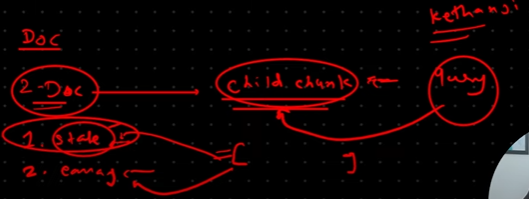